In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import sympy as sp
from ipywidgets import interact
from oetils import init_plotting

In [2]:
_ = init_plotting(latex=True, sans=True)

---

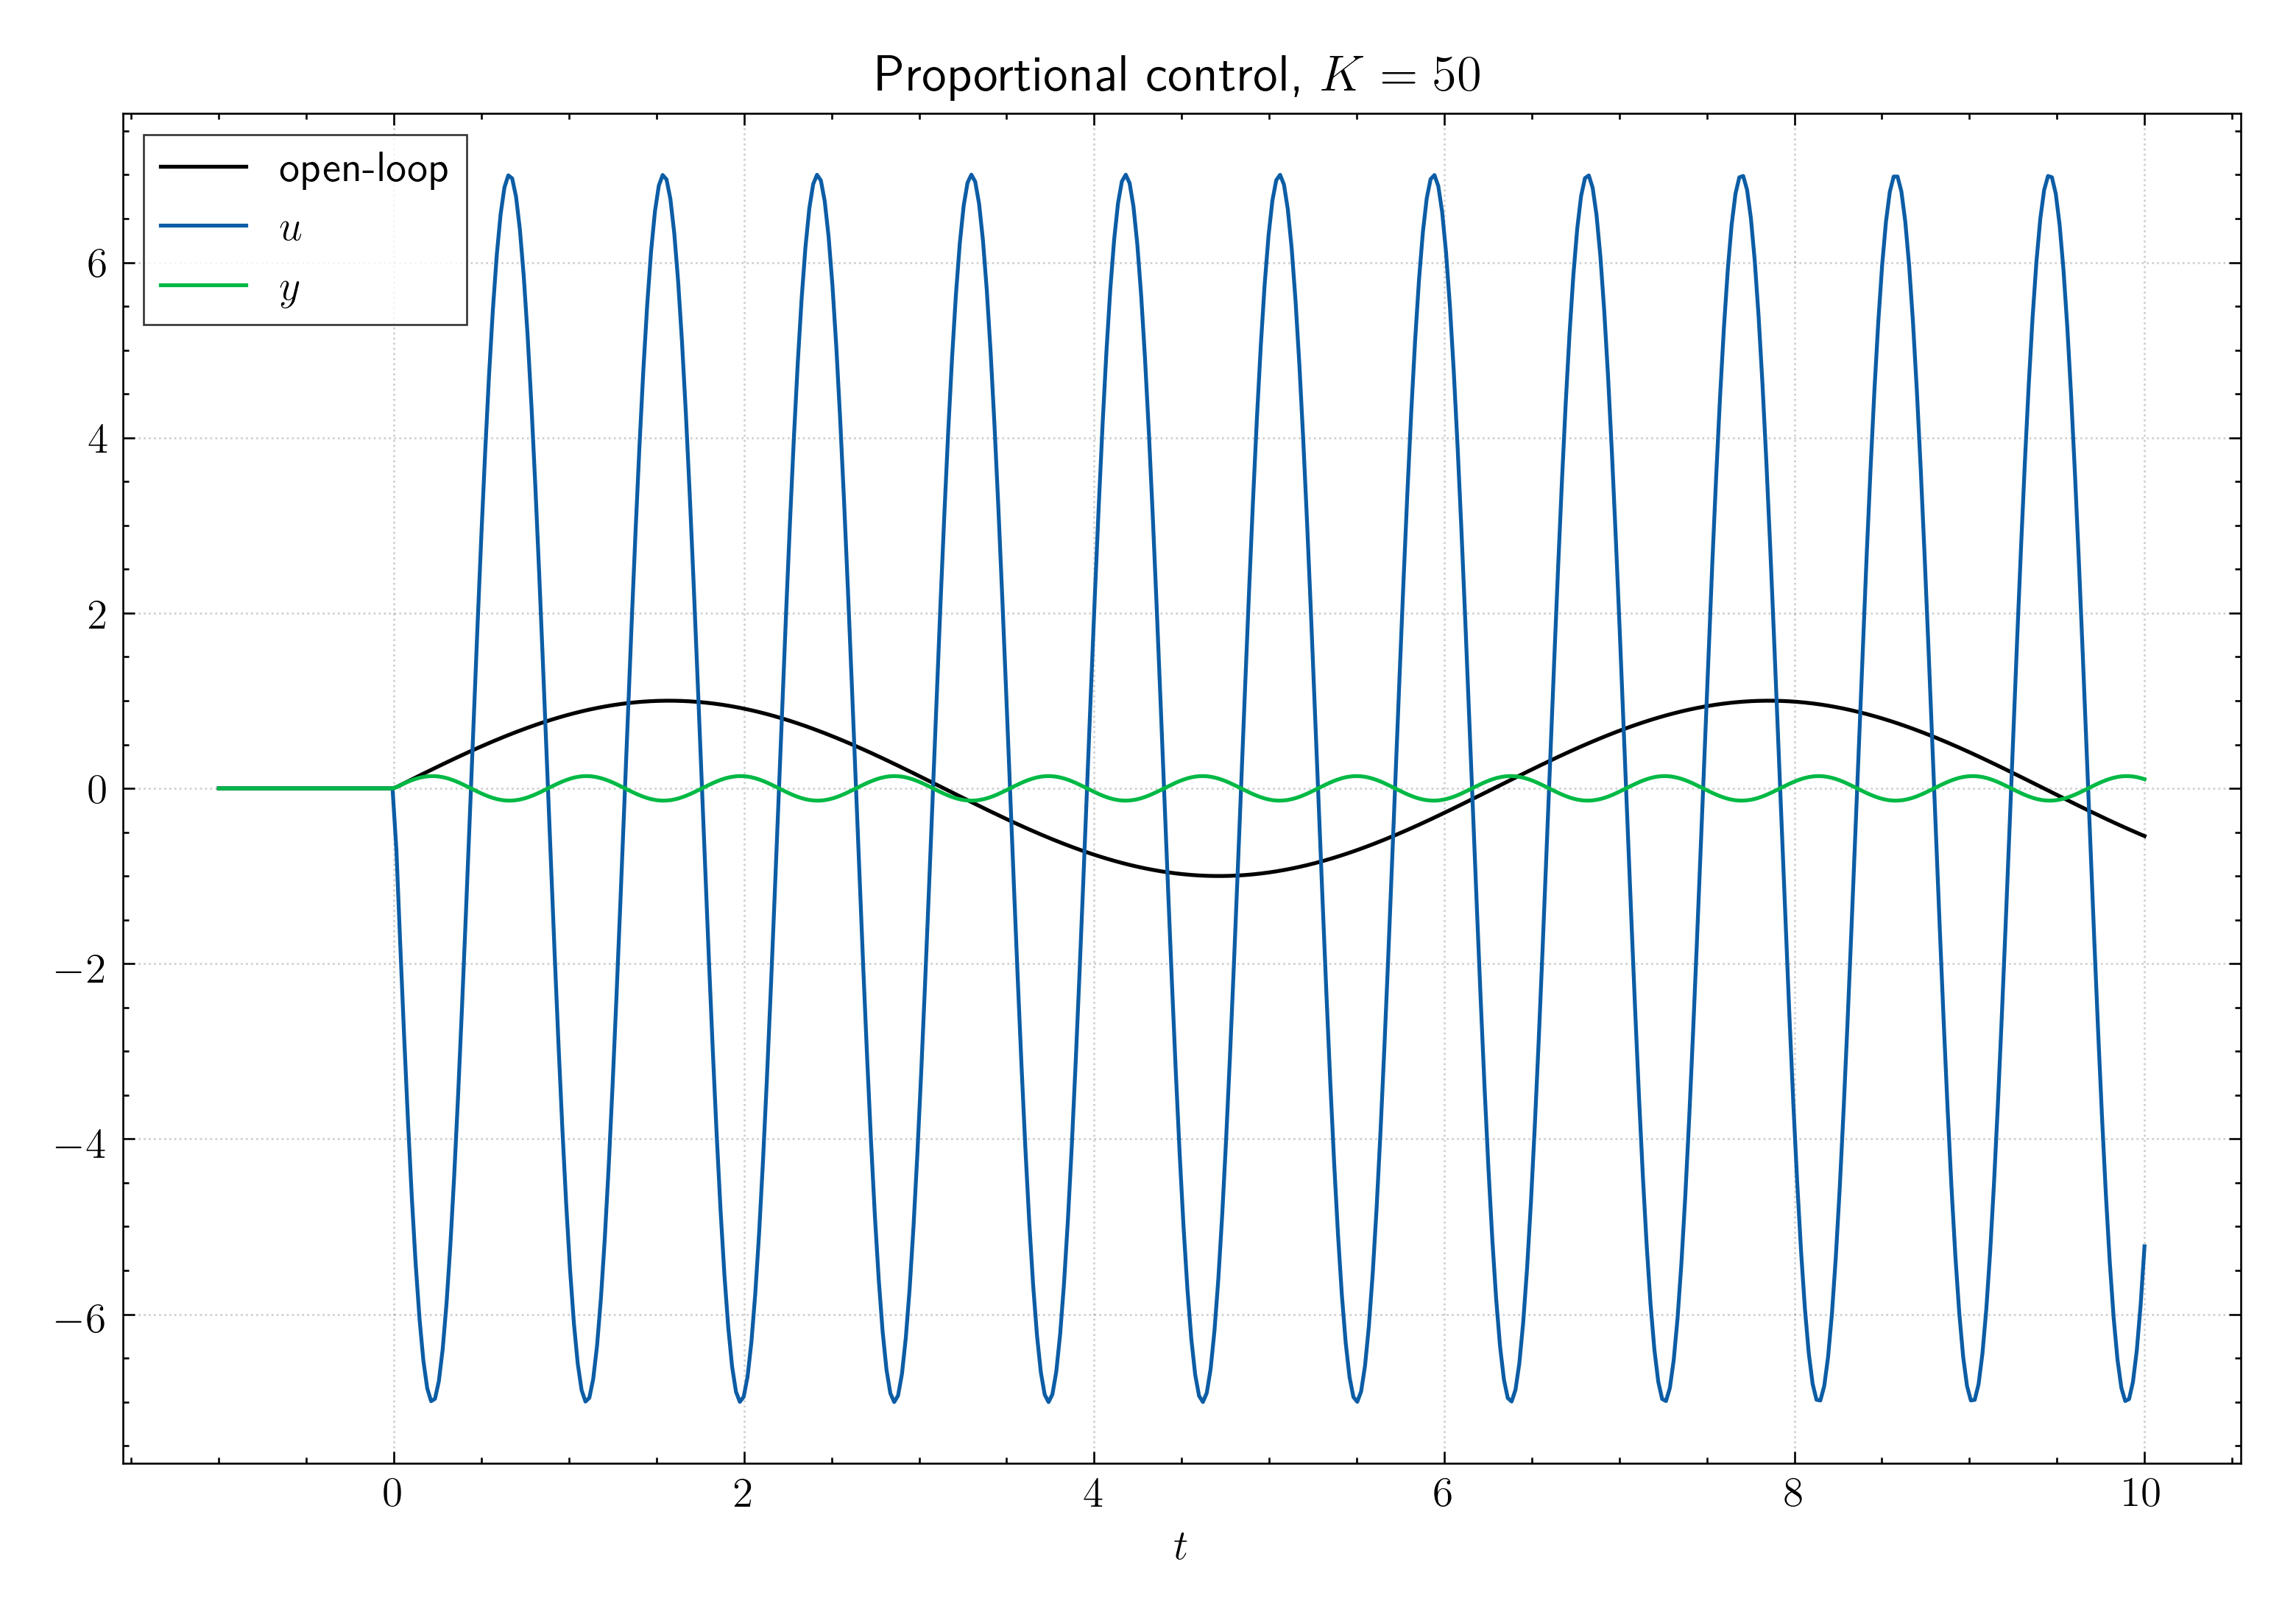

In [3]:
# Proportional control
t = np.linspace(-1, 10, 500)

def plot(K):
    fig, ax = plt.subplots()
    w = np.sqrt(K + 1)
    y = np.where(t < 0, 0, np.sin(w*t) / w)
    u = np.where(t < 0, 0, -K * np.sin(w*t) / w)
    ax.plot(t, np.where(t < 0, 0, np.sin(t)), 'k', label="open-loop")
    ax.plot(t, u, label="$u$")
    ax.plot(t, y, label="$y$")
    ax.set_title(f"Proportional control, $K = {int(K)}$")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, K=widgets.FloatSlider(value=50.0, min=0, max=100, step=1.0))
plot(K=50)

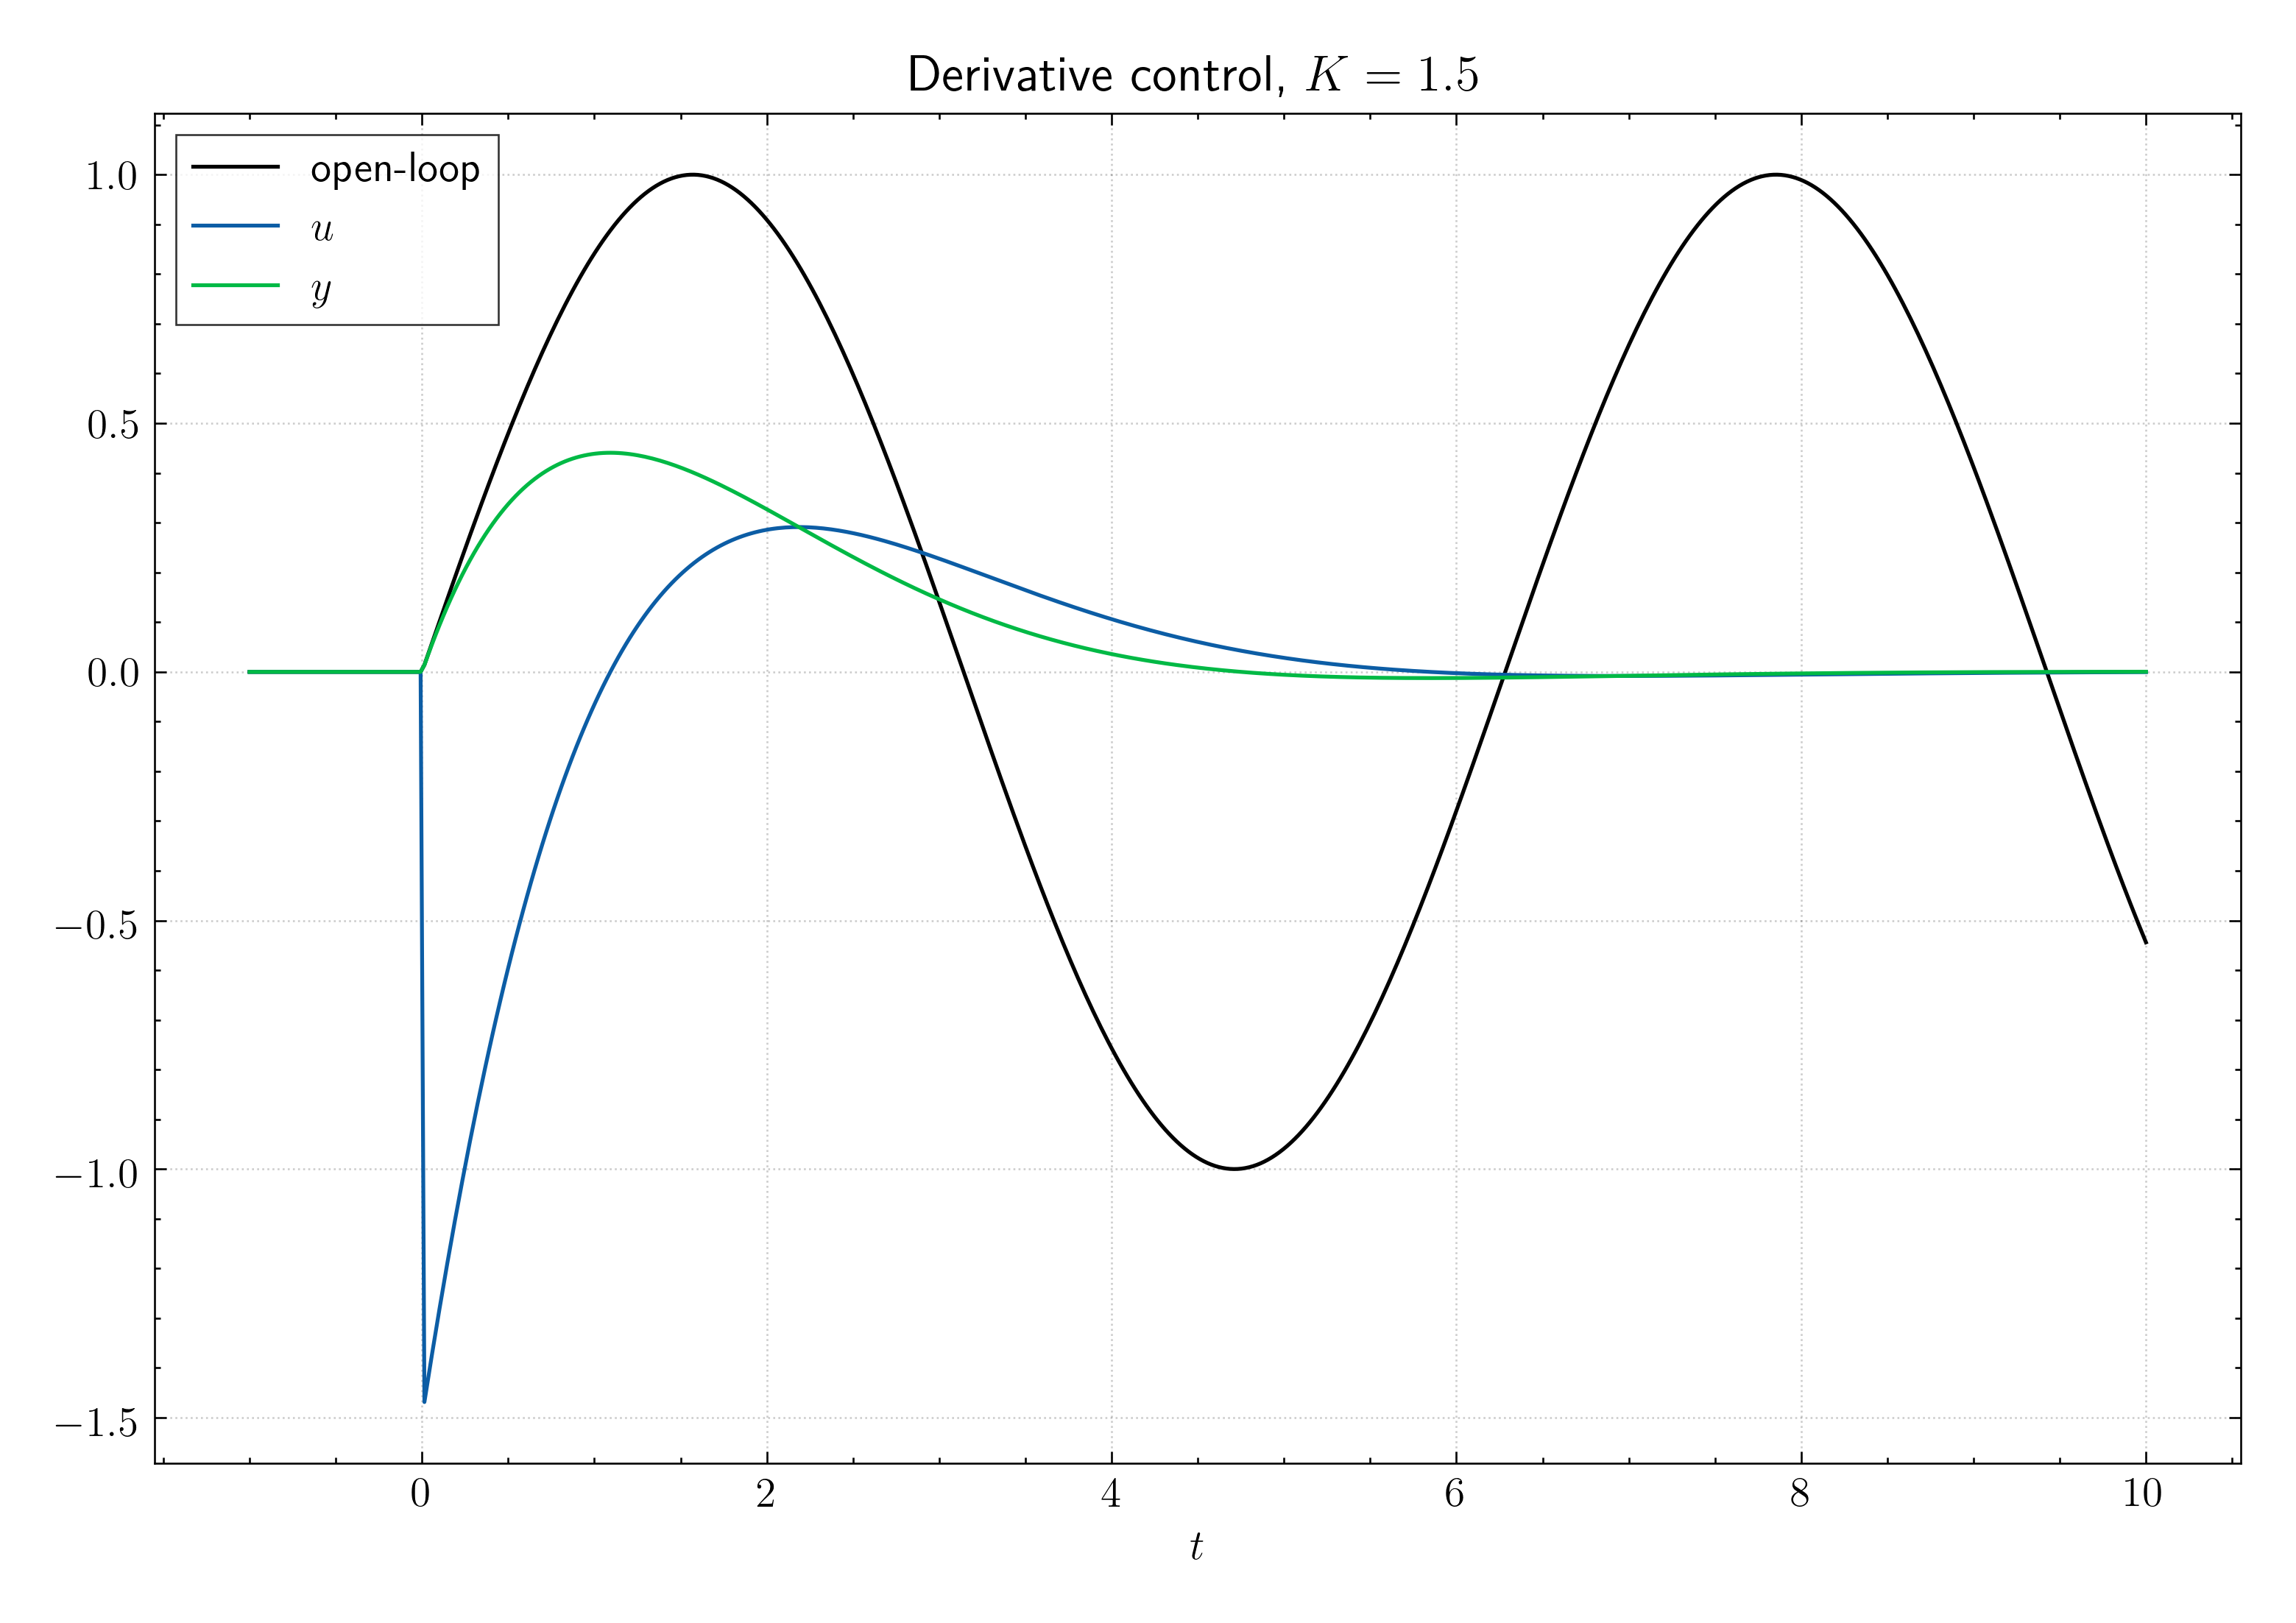

In [4]:
# Derivative control
t = np.linspace(-1, 10, 500)

def plot(K):
    fig, ax = plt.subplots()
    a = K/2
    w = np.sqrt(1 - a**2)
    y = np.where(t < 0, 0, np.exp(-a*t) * np.sin(w*t) / w)
    u = np.where(t < 0, 0, K**2 / (2*w) * np.exp(-a*t) * np.sin(w*t) - K * np.exp(-a*t) * np.cos(w*t))
    ax.plot(t, np.where(t < 0, 0, np.sin(t)), 'k', label="open-loop")
    ax.plot(t, u, label="$u$")
    ax.plot(t, y, label="$y$")
    ax.set_title(f"Derivative control, $K = {K:.1f}$")
    ax.set_xlabel("$t$")
    plt.legend()
    plt.show()

# interact(plot, K=widgets.FloatSlider(value=1.5, min=0, max=2, step=0.1))
plot(K=1.5)

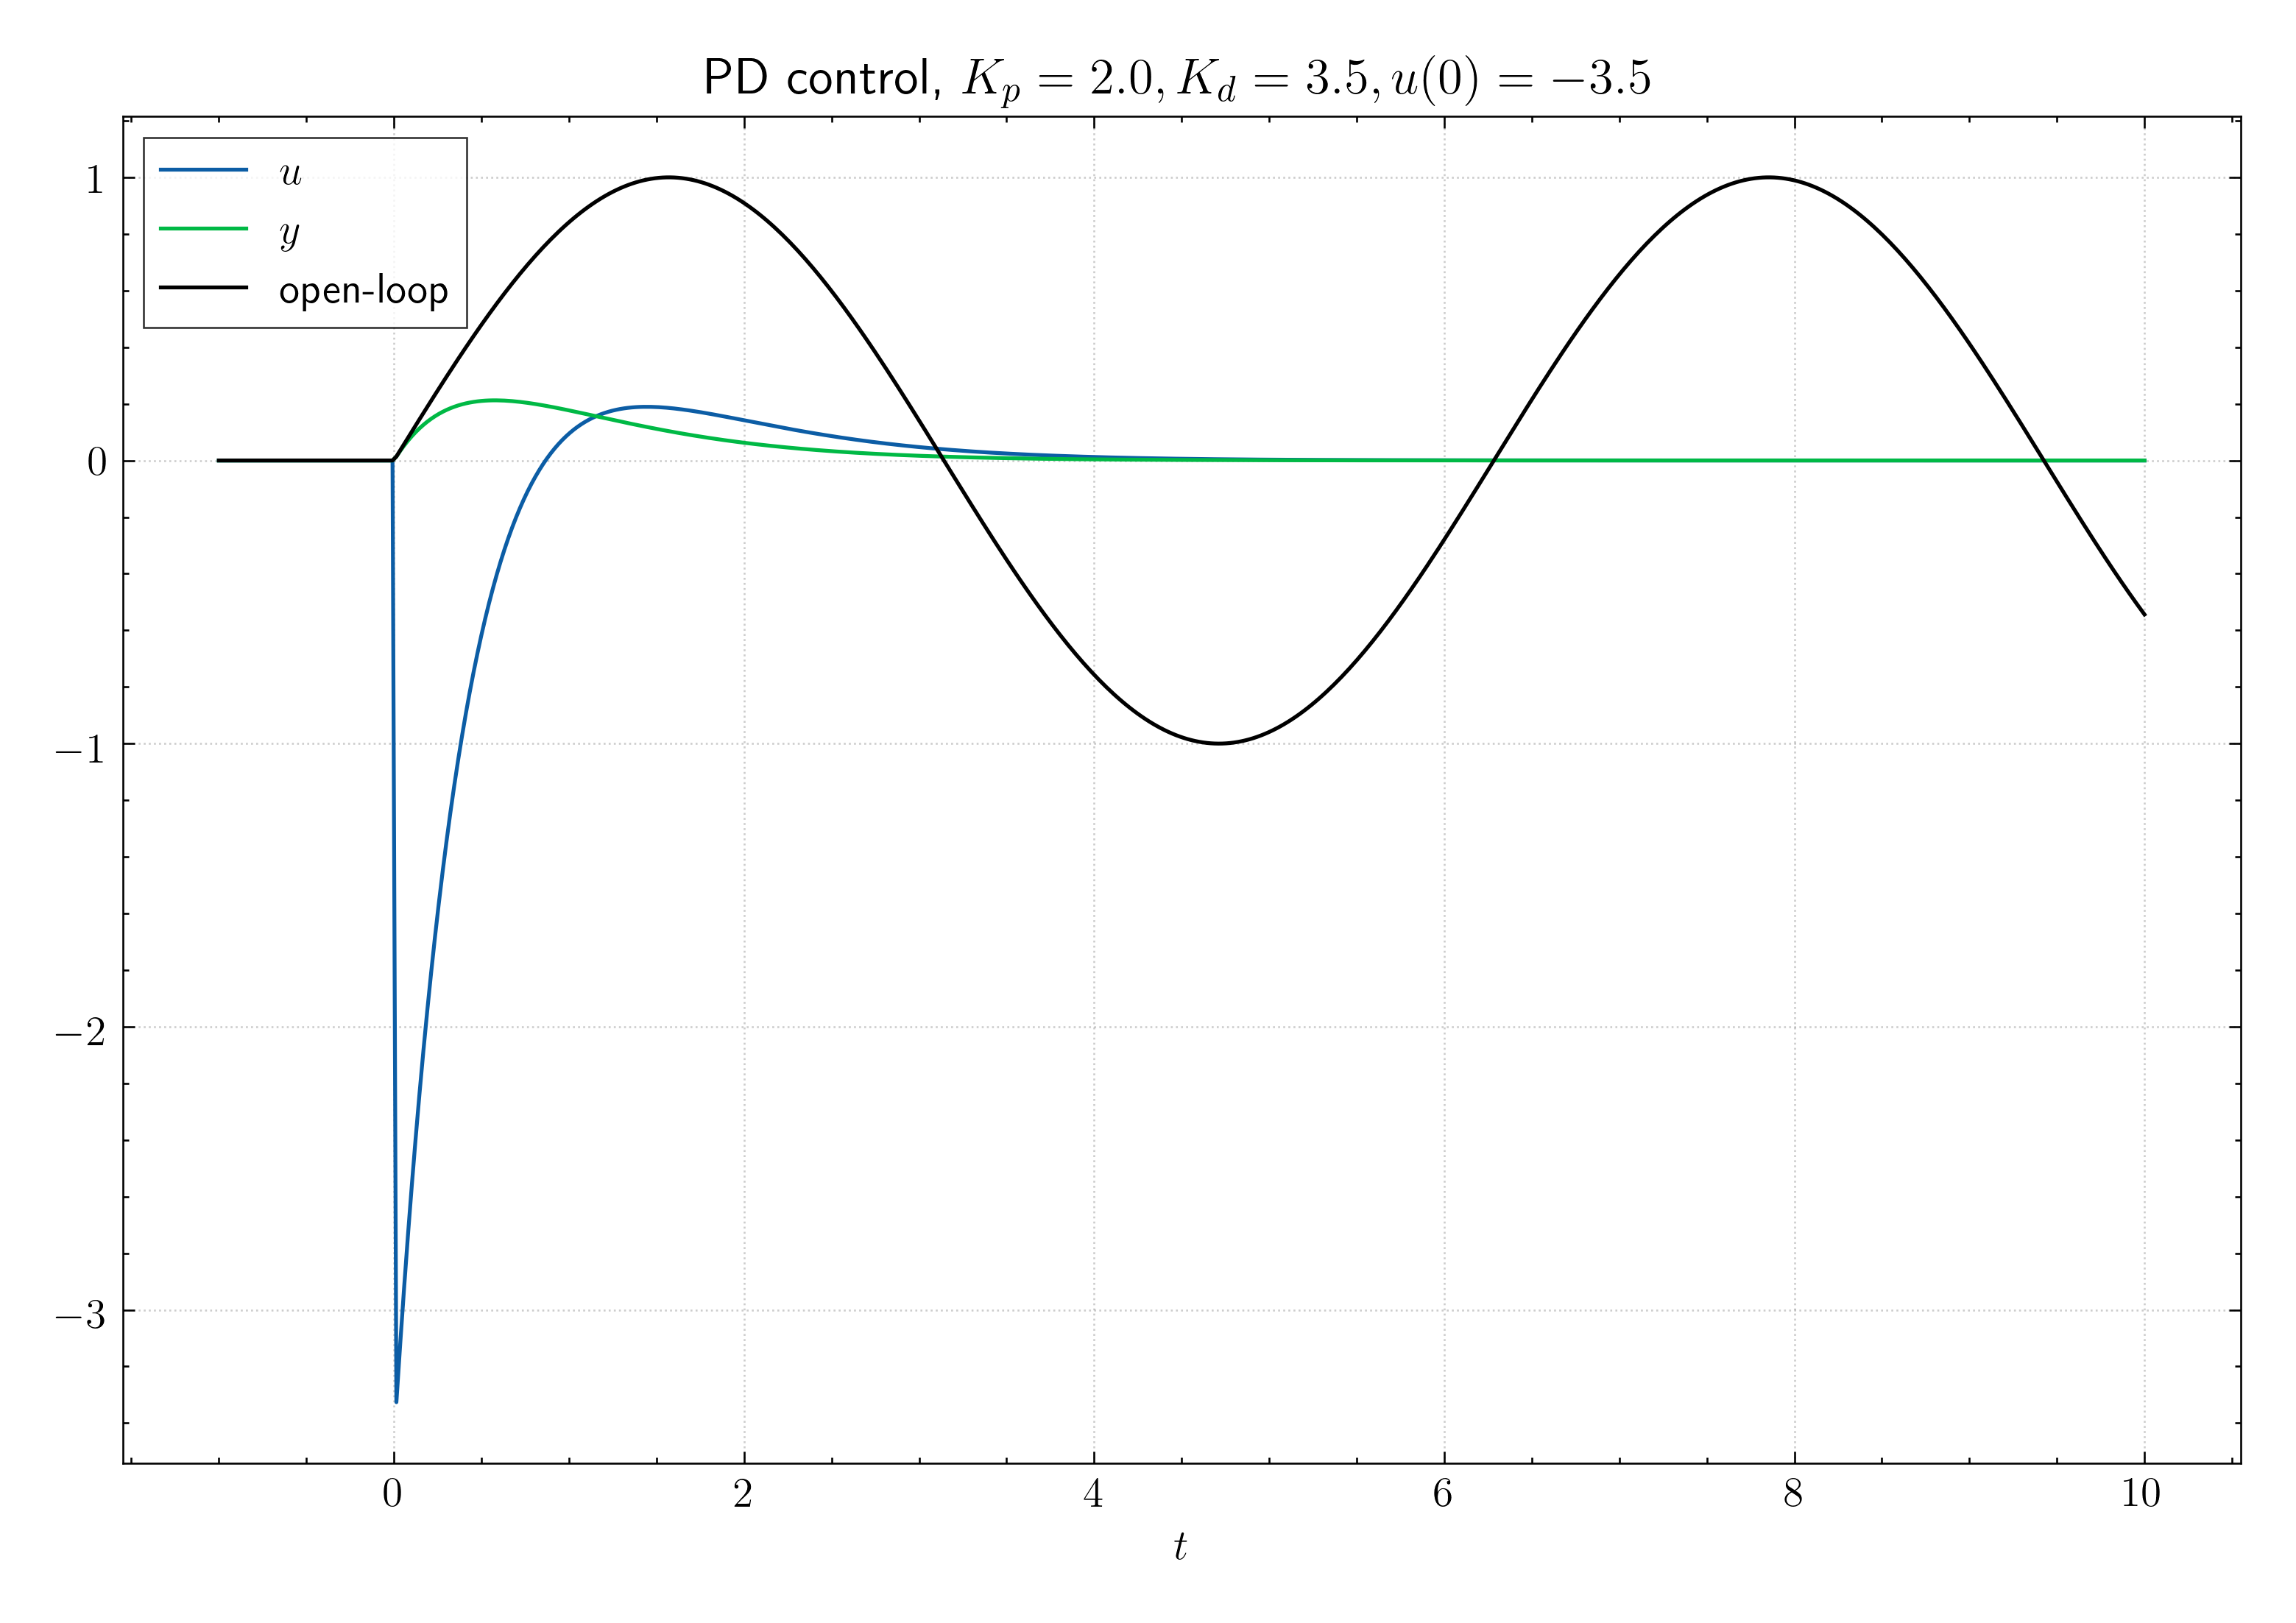

In [5]:
# PD control with critical damping
t = np.linspace(-1, 10, 500)

def plot(K_p):
    fig, ax = plt.subplots()
    y = np.where(t < 0, 0, t * np.exp(-np.sqrt(K_p + 1)*t))
    u = np.where(t < 0, 0, ((K_p + 2)*t - 2*np.sqrt(K_p + 1)) * np.exp(-np.sqrt(K_p + 1)*t))
    # ax.axhline(-2*np.sqrt(K_p + 1), c='C1', ls='--', label='$u(0)$')
    ax.plot(t, u, label="$u$")
    ax.plot(t, y, label="$y$")
    ax.set_title(f"PD control, $K_p = {K_p:.1f}, K_d = {2*np.sqrt(K_p + 1):.1f}, u(0) = {-2*np.sqrt(K_p + 1):.1f}$")
    ax.plot(t, np.where(t < 0, 0, np.sin(t)), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, K_p=widgets.FloatSlider(value=2.0, min=0, max=100, step=0.1))
plot(K_p=2)

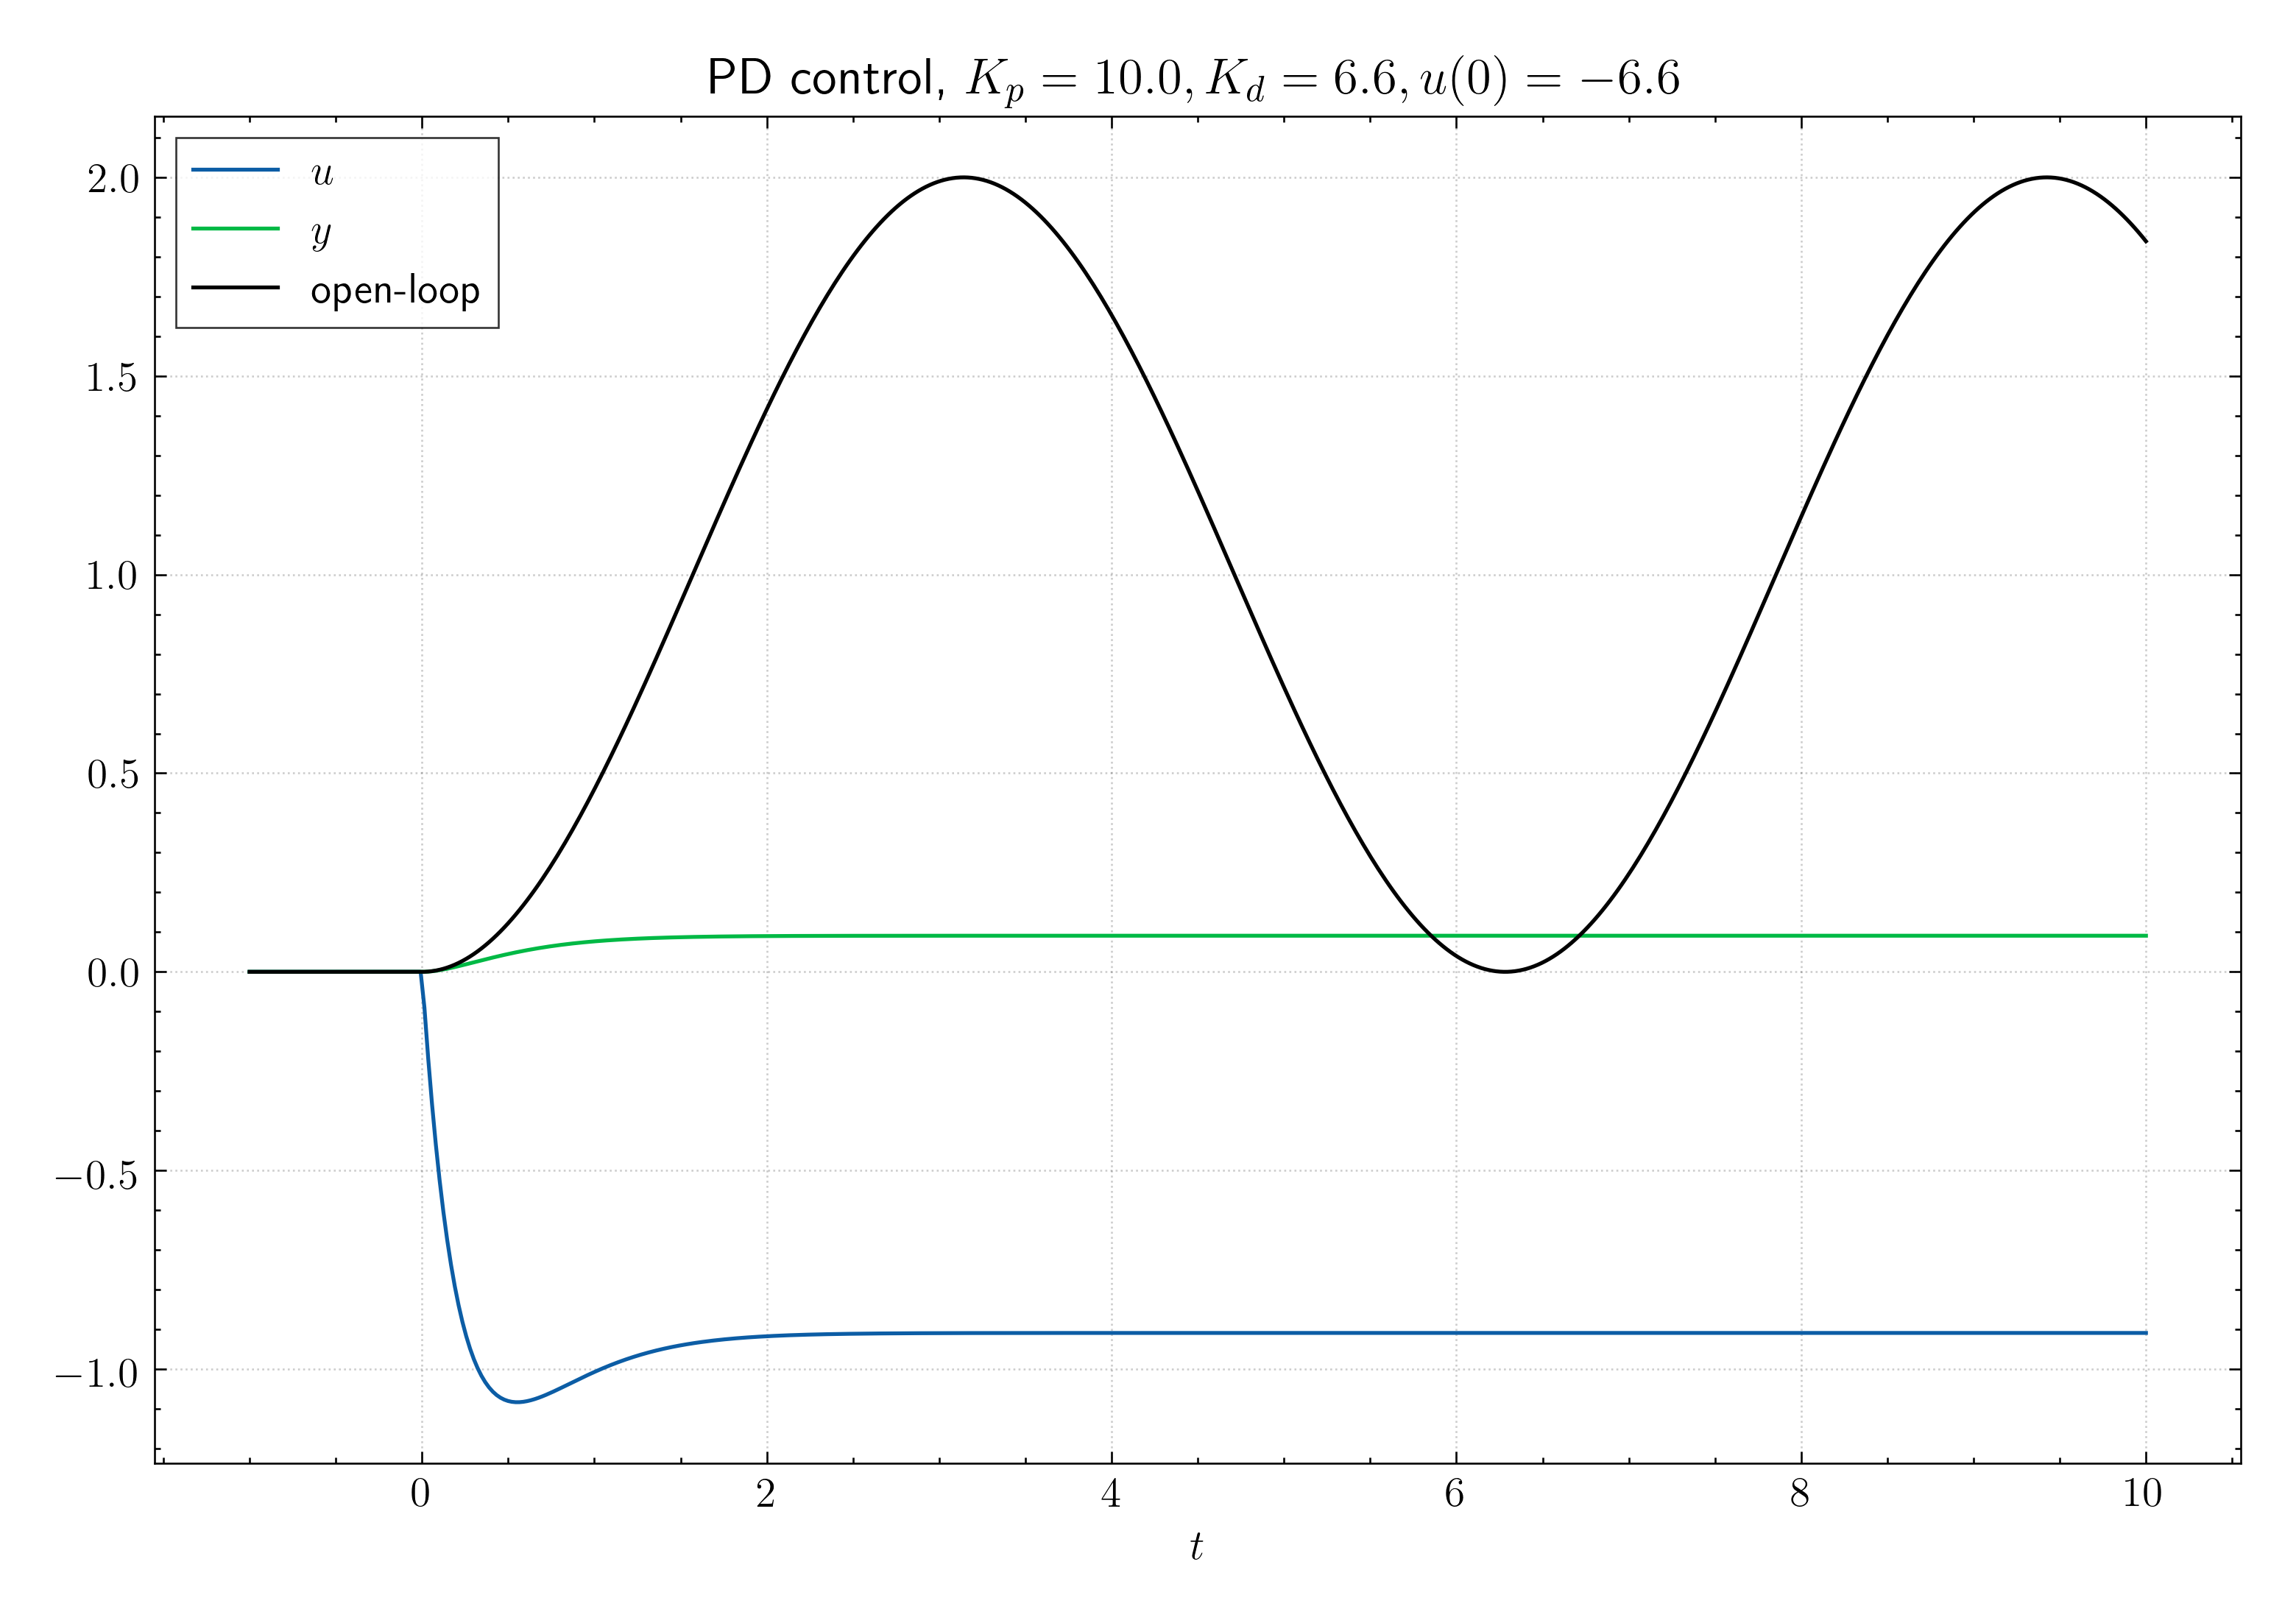

In [6]:
# PD control with critical damping, step response
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_d = sp.S('t, s, K_p, K_d')
G = 1/(1 + s**2)
d = 1/s
K = K_p + K_d*s
y = G / (1 + K*G) * d
u = -K * y
y = y.subs(K_p, (K_d / 2)**2 - 1)
u = u.subs(K_p, (K_d / 2)**2 - 1)
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, K_d), y)
u = sp.lambdify((t, K_d), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * d, s, t))

def plot(K_p):
    fig, ax = plt.subplots()
    K_d = 2*np.sqrt(K_p + 1)
    # u = np.where(t < 0, 0, ((K_p + 2)*t - 2*np.sqrt(K_p + 1)) * np.exp(-np.sqrt(K_p + 1)*t))
    # ax.axhline(-2*np.sqrt(K_p + 1), c='C1', ls='--', label='$u(0)$')
    # ax.plot(t, u, label="$u$")
    ax.plot(t_, u(t_, K_d*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, K_d*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PD control, $K_p = {K_p:.1f}, K_d = {2*np.sqrt(K_p + 1):.1f}, u(0) = {-2*np.sqrt(K_p + 1):.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, K_p=widgets.FloatSlider(value=10.0, min=0, max=100, step=0.1))
plot(K_p=10)

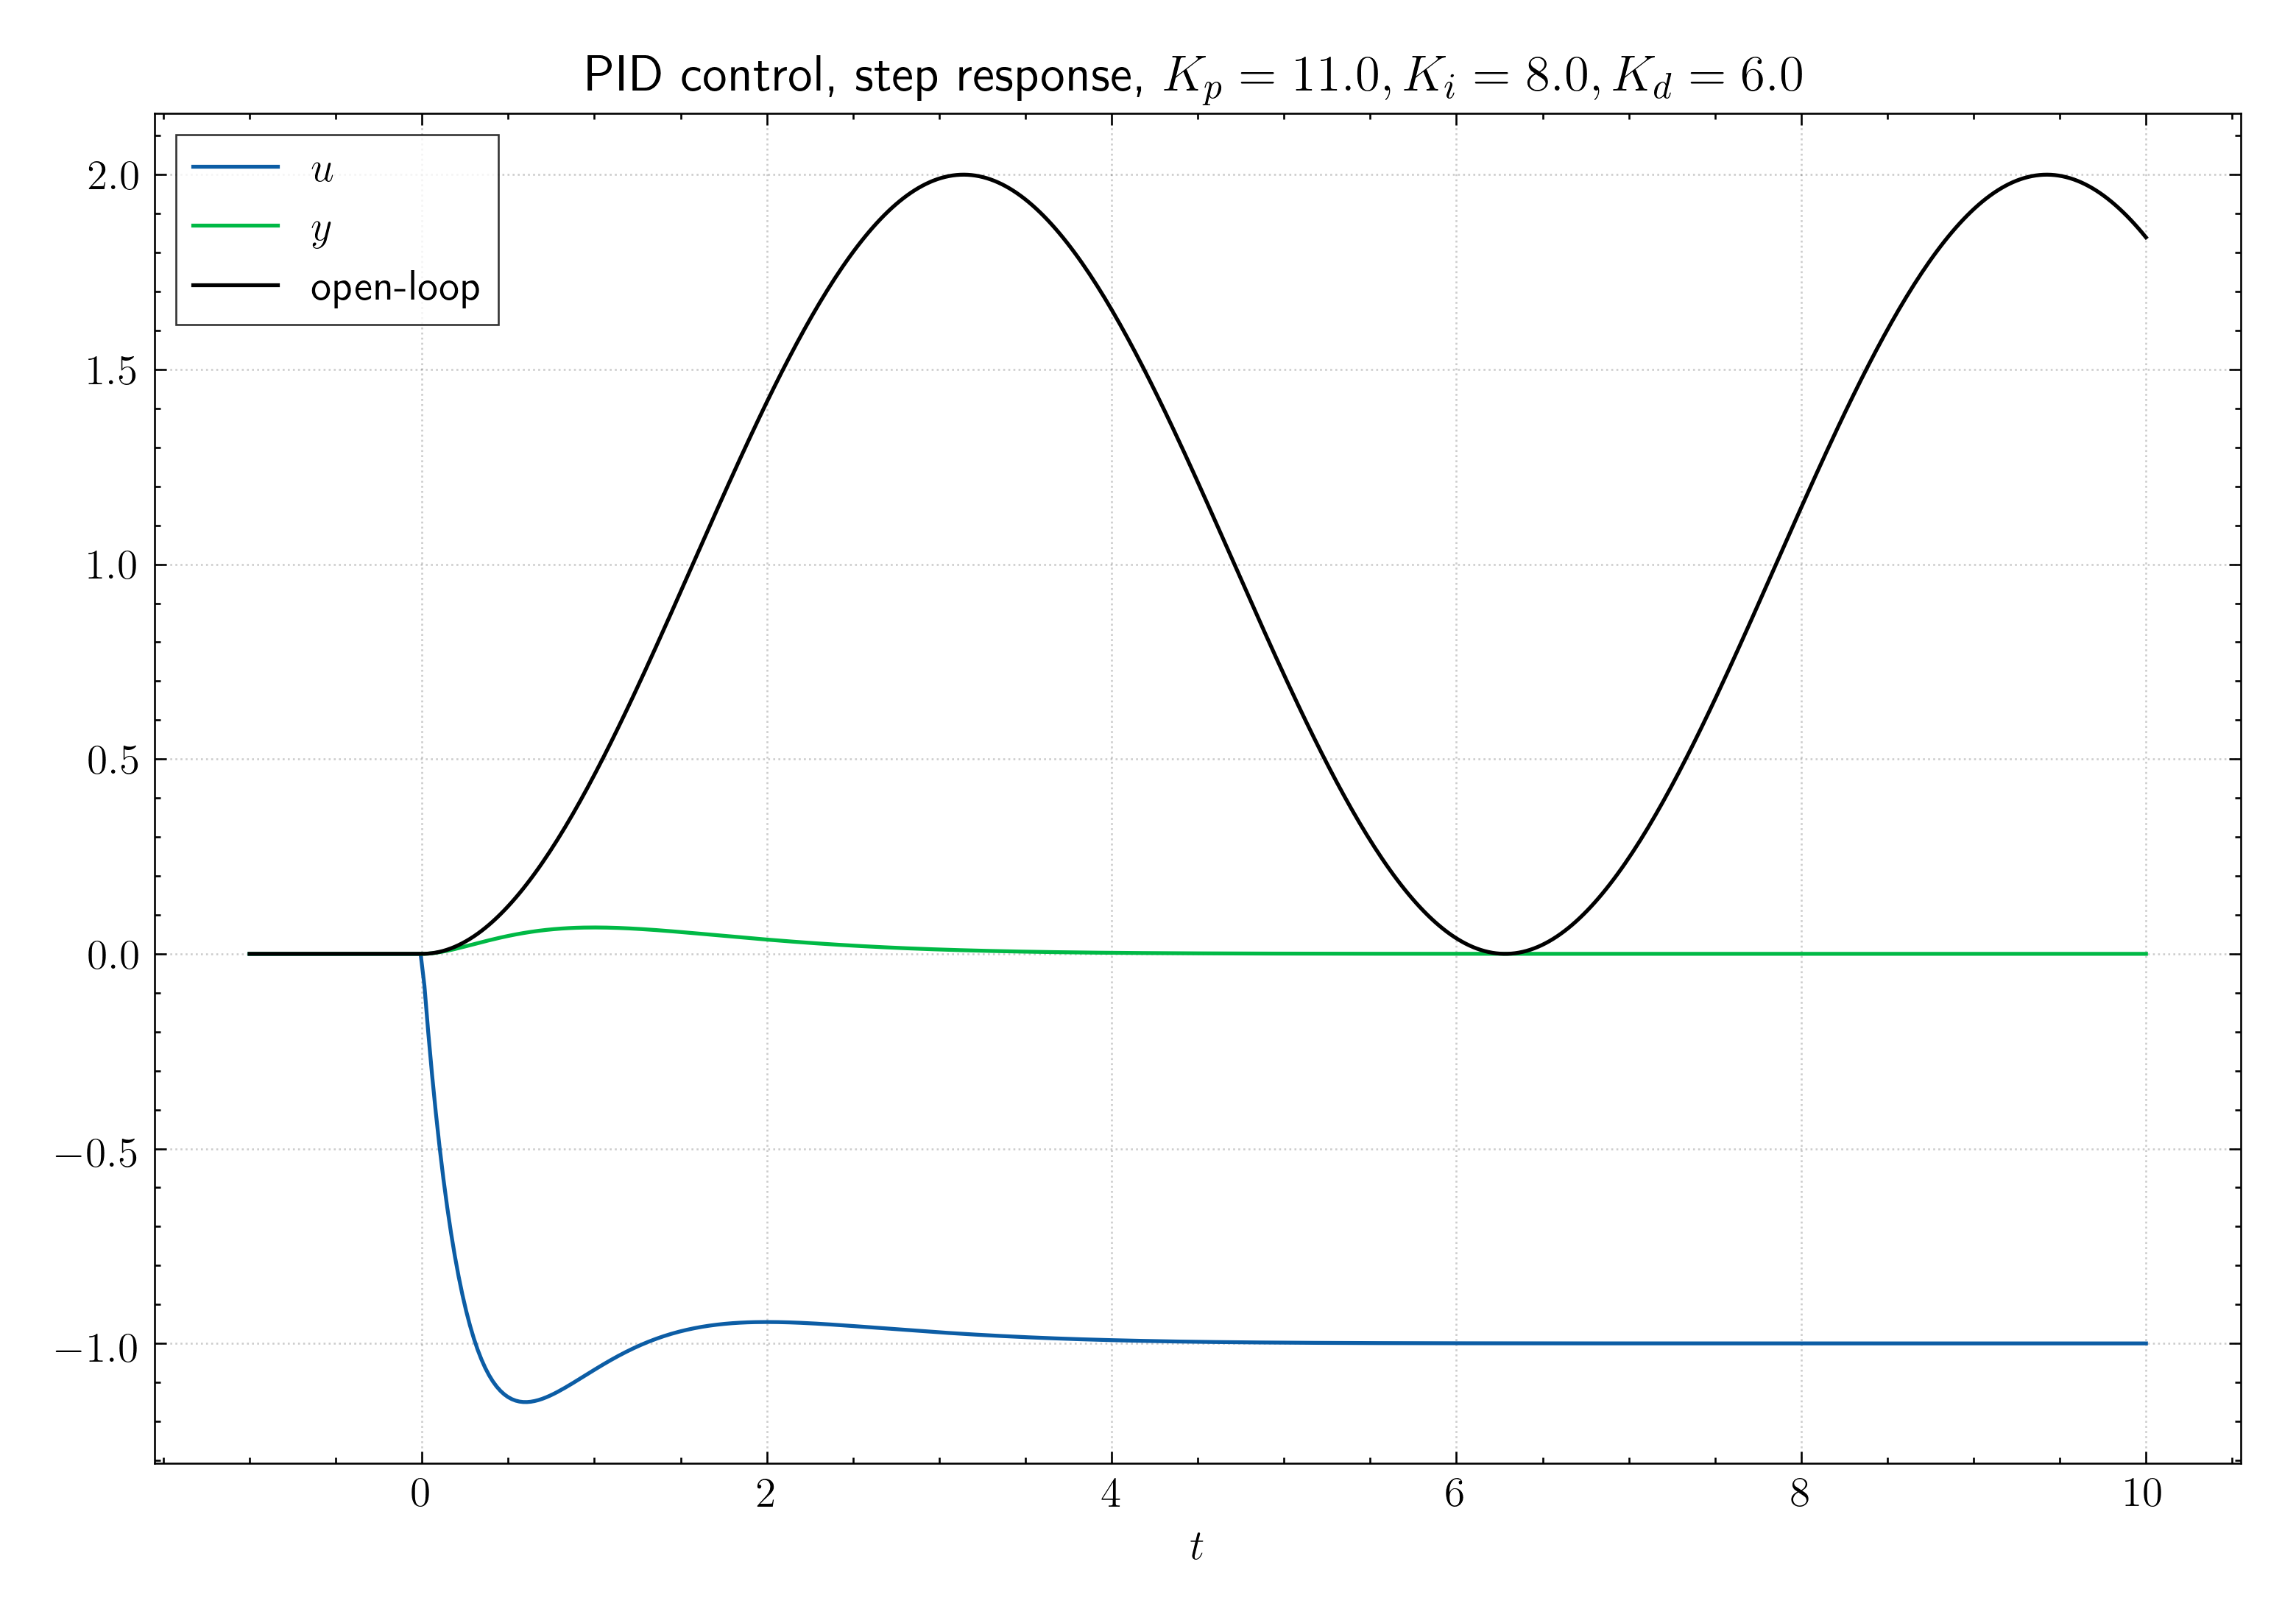

In [7]:
# PID control step response
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
d = 1/s
K = K_p + K_d*s + K_i/s
y = G / (1 + K*G) * d
u = -K * y
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * d, s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, step response, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)

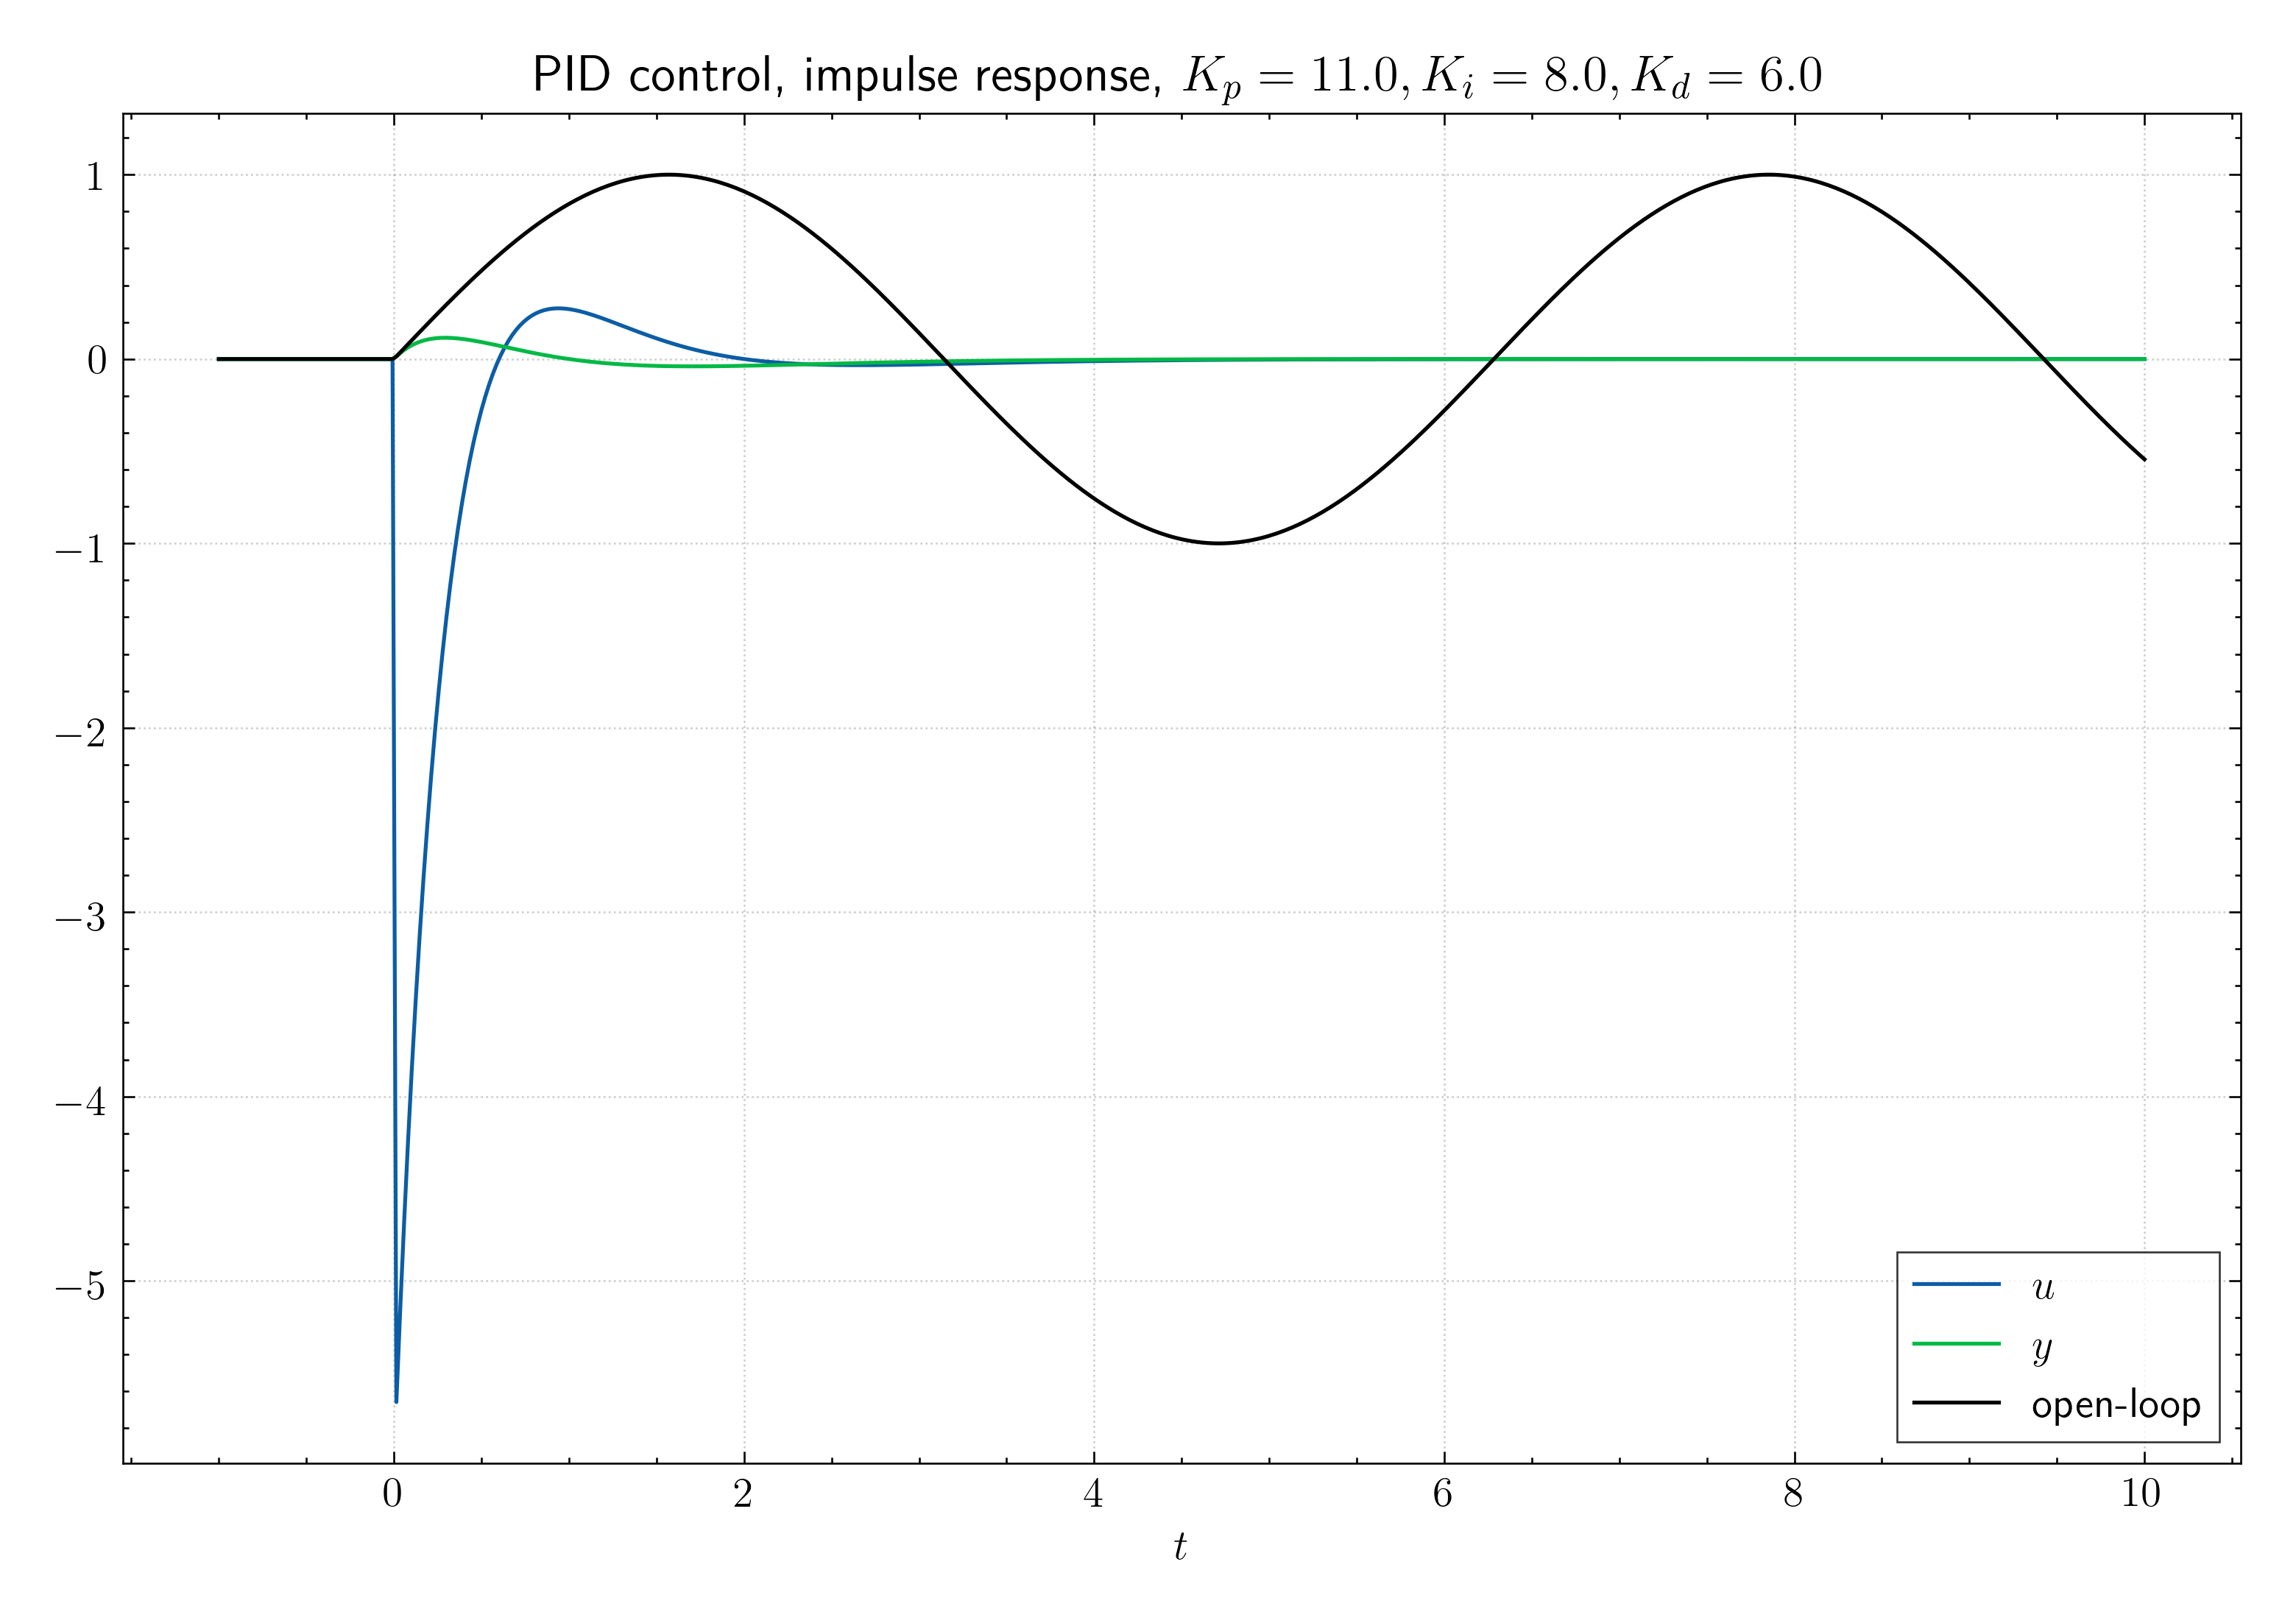

In [8]:
# PID control impulse response
t_ = np.linspace(-1, 10, 500)

t, s, K_p, K_i, K_d, a = sp.S('t, s, K_p, K_i, K_d, a')
params = sp.solve((s + a)**3 - (s**3 + K_d*s**2 + (K_p + 1)*s + K_i), (K_p, K_i, K_d))  # Pole placement
G = 1/(1 + s**2)
d = 1
K = K_p + K_d*s + K_i/s
y = G / (1 + K*G) * d
u = -K * y
y = y.subs((k, v) for k, v in params.items())
u = u.subs((k, v) for k, v in params.items())
y = sp.integrals.inverse_laplace_transform(y, s, t)
u = sp.integrals.inverse_laplace_transform(u, s, t)
y = sp.lambdify((t, a), y)
u = sp.lambdify((t, a), u)
ol = sp.lambdify(t, sp.integrals.inverse_laplace_transform(G * d, s, t))

def plot(a_):
    fig, ax = plt.subplots()
    params_ = {k: v.subs(a, a_) for k, v in params.items()}
    ax.plot(t_, u(t_, a_*np.ones_like(t_)), label="$u$")
    ax.plot(t_, y(t_, a_*np.ones_like(t_)), label="$y$")
    ax.set_title(f"PID control, impulse response, $K_p = {params_[K_p]:.1f}, K_i = {params_[K_i]:.1f}, K_d = {params_[K_d]:.1f}$")
    ax.plot(t_, ol(t_), 'k', label="open-loop")
    ax.set_xlabel("$t$")
    ax.legend()
    plt.show()

# interact(plot, a_=widgets.FloatSlider(value=2.0, min=0, max=10, step=0.1))
plot(a_=2)